In [1]:
import collections
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy.stats import probplot, chi2_contingency, spearmanr
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_predict, StratifiedKFold, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

import sys
sys.path.insert(0, "C:\\Users\\billy\\OneDrive\\Documents\\Python Scripts\\1. Portfolio\\machine-failure\\machine-failure")
import custom_funcs as cf

# Predicting type of machine failure
This workbook details the development of a model for predicting type of machine failure using the [AI4I 2020 Predictive Maintenance Dataset](https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset). This is a synthetic dataset that reflects real predictive maintenance data encountered in industry.

# Scope

**_Context_**

* Business problem: Predicting machine failure through machine learning is paramount for efficient industrial operations. By analysing data patterns, ML models can forecast potential breakdowns, allowing for proactive maintenance and minimising downtime. This predictive approach not only enhances equipment reliability but also optimises resource allocation.

* Implications of incorrect predictions: It will be assumed that faulty machinery would lead to decreased productivity and efficiency, quality issues, defective products, and potentially safety concerns for workers.

**_Model_**

* The machine failure consists of five independent failure modes. Consequently, the problem will be approached as multiclass classification.

* No baseline model is available for benchmarking. The model will therefore be compared to a no-skill classifier.

**_Technical requirements_**

* In reality, the model would likely be deployed to an online endpoint so predictions could be generated in real time (via a REST API).

* At this stage, the model will not be deployed. However, the low latency requirements of online deployment does place constraints on infrastructure and model complexity. For this reason, neural networks will not be tested as they can be slow at inference time due to the large number of operations.

**_Data requirements_**

* No further data collection is required.

* No personal data is involved. Consequently there are no apparent legal/ethical constraints (e.g. GDPR).

# Summary of findings

TBC

# Import cleaned data

In [2]:
# Training data
clean_train_df = pd.read_csv('../data/cleaned/clean_train.csv')
print(f"Number of rows: {clean_train_df.shape[0]}")
print(f"Number of columns: {clean_train_df.shape[1]}")
clean_train_df.head(5)

Number of rows: 8000
Number of columns: 9


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Failure Type
0,9255,L56434,L,298.3,309.1,1616,31.1,195,No Failure
1,1562,L48741,L,298.2,308.4,1388,53.8,137,No Failure
2,1671,L48850,L,298.2,307.8,1528,31.1,194,No Failure
3,6088,M20947,M,300.9,310.8,1599,33.0,7,No Failure
4,6670,L53849,L,301.4,310.5,1571,33.9,208,No Failure


In [3]:
# Test data
clean_test_df = pd.read_csv('../data/cleaned/clean_test.csv')
print(f"Number of rows: {clean_test_df.shape[0]}")
print(f"Number of columns: {clean_test_df.shape[1]}")
clean_train_df.head(5)

Number of rows: 2000
Number of columns: 9


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Failure Type
0,9255,L56434,L,298.3,309.1,1616,31.1,195,No Failure
1,1562,L48741,L,298.2,308.4,1388,53.8,137,No Failure
2,1671,L48850,L,298.2,307.8,1528,31.1,194,No Failure
3,6088,M20947,M,300.9,310.8,1599,33.0,7,No Failure
4,6670,L53849,L,301.4,310.5,1571,33.9,208,No Failure


In [5]:
# Update cust_unique_id -> categorical dtype
clean_train_df['UDI'] = pd.Categorical(
    clean_train_df['UDI'], list(clean_train_df['UDI'].unique()), ordered=True
)
clean_test_df['UDI'] = pd.Categorical(
    clean_test_df['UDI'], list(clean_test_df['UDI'].unique()), ordered=True
)

In [6]:
print(f'\n-----------------------------Training set-----------------------------\n')
display(clean_train_df.info())
print(f'\n-----------------------------Test set-----------------------------\n')
display(clean_train_df.info())


-----------------------------Training set-----------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   UDI                      8000 non-null   category
 1   Product ID               8000 non-null   object  
 2   Type                     8000 non-null   object  
 3   Air temperature [K]      8000 non-null   float64 
 4   Process temperature [K]  8000 non-null   float64 
 5   Rotational speed [rpm]   8000 non-null   int64   
 6   Torque [Nm]              8000 non-null   float64 
 7   Tool wear [min]          8000 non-null   int64   
 8   Failure Type             8000 non-null   object  
dtypes: category(1), float64(3), int64(2), object(3)
memory usage: 836.3+ KB


None


-----------------------------Test set-----------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   UDI                      8000 non-null   category
 1   Product ID               8000 non-null   object  
 2   Type                     8000 non-null   object  
 3   Air temperature [K]      8000 non-null   float64 
 4   Process temperature [K]  8000 non-null   float64 
 5   Rotational speed [rpm]   8000 non-null   int64   
 6   Torque [Nm]              8000 non-null   float64 
 7   Tool wear [min]          8000 non-null   int64   
 8   Failure Type             8000 non-null   object  
dtypes: category(1), float64(3), int64(2), object(3)
memory usage: 836.3+ KB


None

# Descriptive statistics

## Summary statistics

**1) Continuous variables**
* The difference in magnitude between the mean and median of rotational speed suggests a positive skew in its frequency distribution.

* The mean and median values are similar for all other variables. This suggests they exhibit symmetric frequency distributions.

In [7]:
clean_train_df.select_dtypes(include=['number']).describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,300.009925,310.006088,1538.776625,40.007800,108.068750
std,2.002224,1.486484,180.594083,9.979156,63.225052
min,295.300000,305.700000,1181.000000,3.800000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000
50%,300.100000,310.100000,1502.000000,40.200000,108.000000
75%,301.500000,311.100000,1611.250000,46.800000,162.000000
max,304.500000,313.800000,2886.000000,76.200000,253.000000


**2) Categorical variables**
* No duplicate values are present in 'UDI' and 'Product ID'.

* The number of unique values in the 'Type' and 'Failure Type' columns is relatively low.

In [8]:
clean_train_df.select_dtypes(include=['object', 'category']).describe()

,UDI,Product ID,Type,Failure Type
count,8000,8000,8000,8000
unique,8000,8000,3,6
top,9255,L56434,L,No Failure
freq,1,1,4776,7717


## Frequency distributions

**_1) Continuous variables_**

* A relatively uniform distribution is observed for Tool Wear

* A positive skew is exhibited by Rotational Speed.

* The Air Temperature, Process Temperature and Torque variables' distributions appear roughly normal.

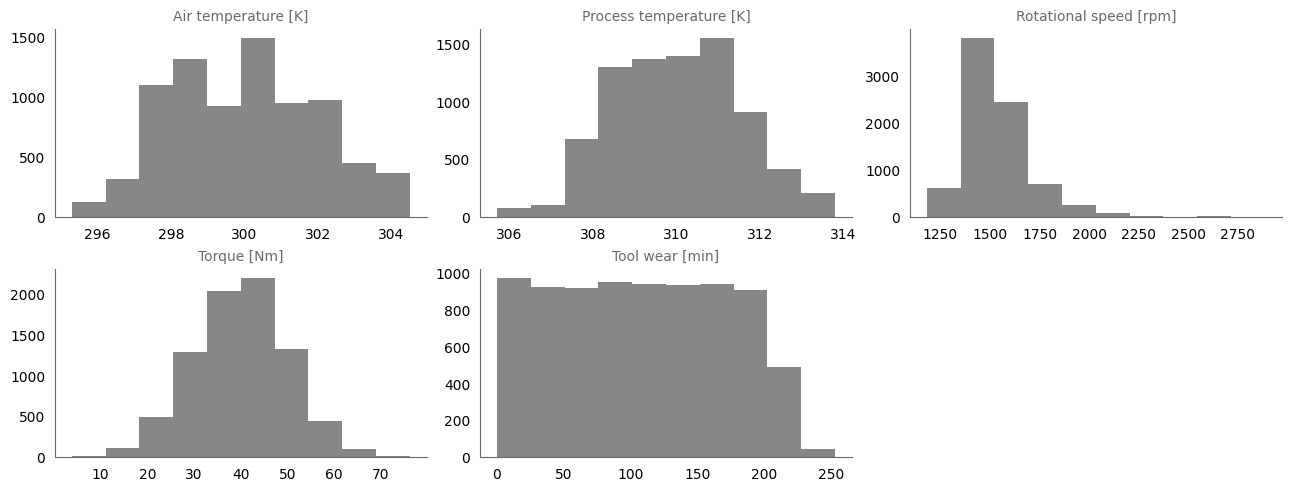

In [9]:
fig, axes = plt.subplots(
    nrows=2, ncols=3, constrained_layout=True, figsize=(6.4*2, 4.8)
)
i = 0
axes = axes.flatten()
for col in clean_train_df.select_dtypes(include=['number']).columns:
    axes[i].hist(clean_train_df[col], color='dimgray', alpha=0.8, label='')
    axes[i].set_title(col, fontsize=10, color='dimgray')
    i += 1

for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')
fig.delaxes(axes[5])

**2) Categorical variables**
* No duplicate values are present in 'UDI' and 'Product ID'

* The distributions of 'Type' and 'Failure Type' are imbalanced.

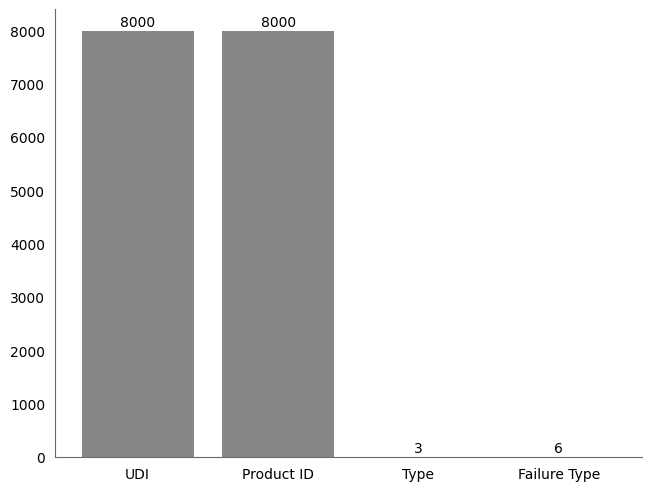

In [10]:
# Cardinality
fig, ax = plt.subplots(
    nrows=1, ncols=1, constrained_layout=True, figsize=(6.4, 4.8))
ax.tick_params(bottom=False, left=False)
ax.grid(False)
ax.spines[['top', 'right']].set_visible(False)
ax.spines[['left', 'bottom']].set_color('dimgray')

col_cardinality = clean_train_df.select_dtypes(include=['object', 'category']).nunique()
bars = ax.bar(col_cardinality.index, col_cardinality.values, color='dimgray', alpha=0.8)
ax.bar_label(bars, padding=1);

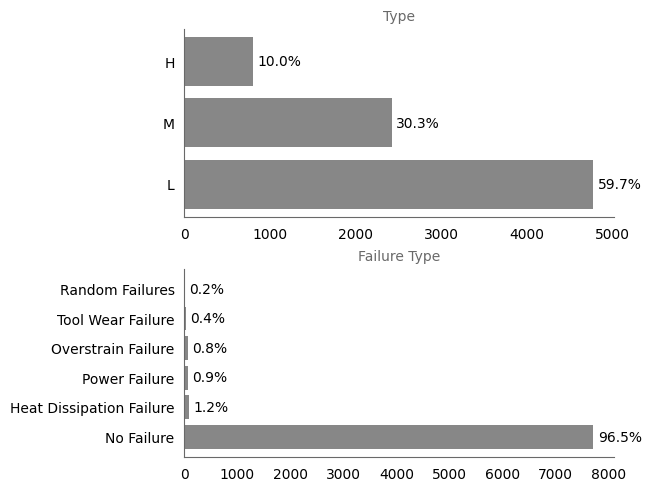

In [12]:
# Frequency plots
fig, axes = plt.subplots(
    nrows=2, ncols=1, constrained_layout=True, figsize=(6.4, 4.8)
)
i = 0
for col in ['Type', 'Failure Type']:
    counts = clean_train_df[col].value_counts()
    percs = clean_train_df[col].value_counts(normalize=True)
    rects = axes[i].barh(counts.index, counts.values,
                         color='dimgray', alpha=0.8)
    axes[i].bar_label(rects, labels=[str(round(x*100, 1)) +
                      '%' for x in percs.values], padding=3)
    axes[i].set_title(col, fontsize=10, color='dimgray')
    i += 1
for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')

## Missing values
* Prior data exploration showed no missing values are present.

## Outliers
* The Rotational Speed column has a positive skew. However, no outliers are obviously present.

    Note: The influence of large values on later modelling will be assessed. If a point significantly affects outcomes, it may be excluded.

## Pairwise associations

### Continuous-continuous
* Linear relationships are observed between many of the variables.

* A non-linear monotonic relationship is observed between torque and rotational speed.

* Pearson correlation coefficient is used to estimate the strength of linear associations.

    * Given the observed departure from normality for rotational speed and tool wear, corresponding values should be treated as rough estimates of association strength.
 
    * The correlation matrix indicates multicollinearity among the predictive variables 'Air temperature' and 'Process temperature'.

    * 'Tool wear' does not appear to be strongly correlated with any variables.

* Spearman' rank is used to estimate the strength of the nonlinear association between torque and rotational speed. This confirmed a strong monotonic negative association between the two variables.

#### Background

**_1) Covariance_**

* Definition:

    $Cov(X,Y) = \mathbb{E}\bigl[(X-\mathbb{E}X)(Y-\mathbb{E}Y) \bigr]$

* Properties:

    $Cov(X,Y) \in [-\infty, +\infty]$

    $Cov(X, Y) = 0: $ No linear association between $X$ & $Y$

* Assumptions:

    * Normal distribution for $X$ and $Y$

    * Linear relationship between $X$ and $Y$
 
**_2) Pearson correlation coefficient_**

* Definition:

    $r = \frac{Cov(X, Y)}{\sqrt{Var(X)Var(Y)}} = \frac{Cov(X, Y)}{Std(X)Std(Y)}$

* Properties:

    $r \in [-1, 1]$

    $r=1:$ Perfect $+ve$ linear correlation where $Y=mX + c$ and $m>0$

    $r=-1:$ Perfect $-ve$ linear correlation where $Y=mX + c$ and $m<0$

    $r=0:$ No linear association between $X$ and $Y$ (aka independence)

* Assumptions:

    * Normal distribution for $X$ and $Y$

    * Linear relationship between $X$ and $Y$

**_3) Spearman's rank correlation coefficient_**

* Definition:

    $r_s = \frac{Cov\bigl(r(X), r(Y)\bigr)}{\sqrt{Var\bigl(r(X)\bigr)Var\bigl(r(Y)\bigr)}} = \frac{Cov\bigl(r(X), r(Y)\bigr)}{Std\bigl(r(X)\bigr)Std\bigl(r(Y)\bigr)}$

    *Where the raw scores for $X$ and $Y$ are converted to ranks.*

* Properties:

    $r_s \in [-1, 1]$

    $r_s = 1:$ Observations in $X$ and $Y$ have the same rank. Perfectly increasing monotonic relationship. 

    $r_s = -1:$ Observations in $X$ and $Y$ have opposing ranks. Perfectly decreasing monotonic relationship. 

    $r_s = 0:$ No monotonic relationship.

* Assumptions:

    - Non-parametric
      
    - Relationship between $X$ and $Y$ must be monotonic (entirely non-increasing or non-decreasing)

#### Analyses

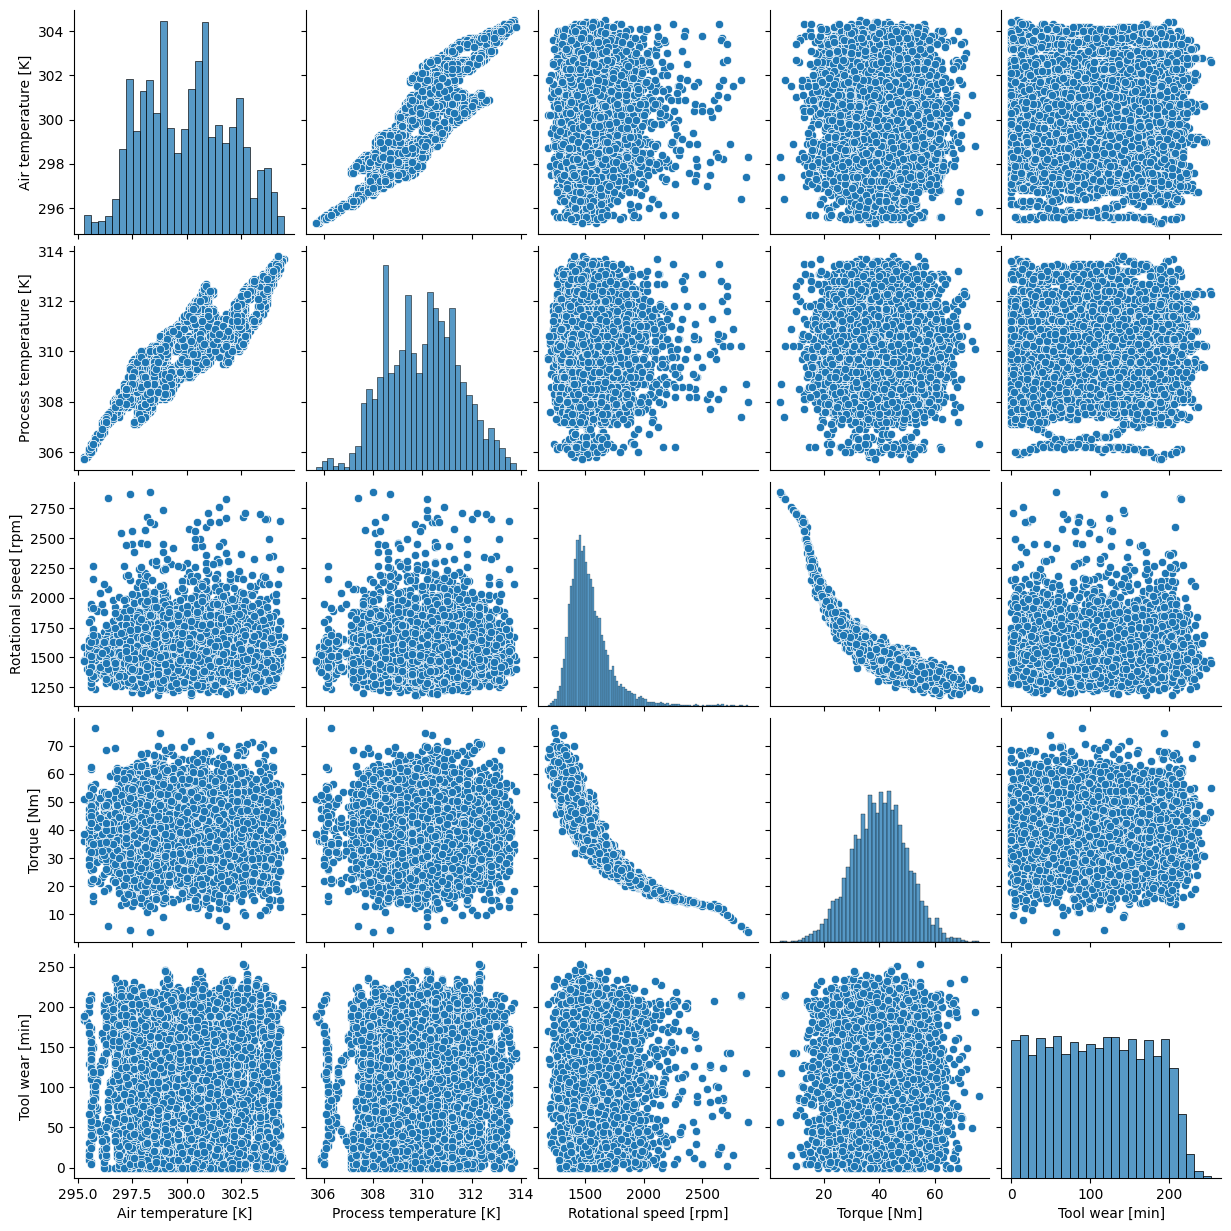

In [13]:
# Matrix of scatter plots
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
sns.pairplot(
    clean_train_df.select_dtypes(include=['number']), diag_kind='hist'
)

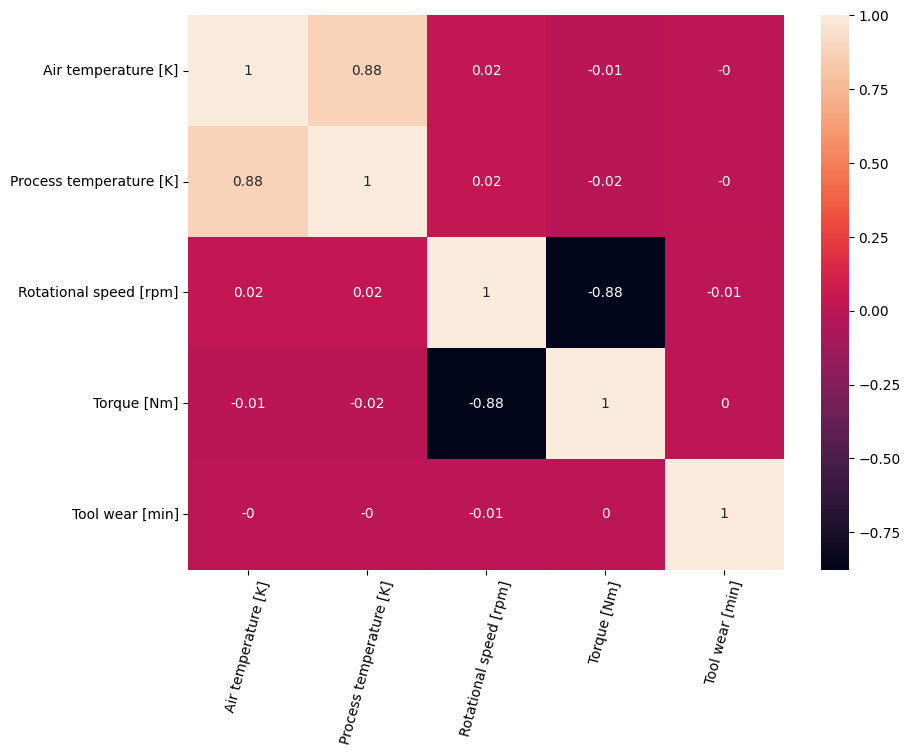

In [14]:
# Pearson correlation matrix
pearson_corr = clean_train_df.select_dtypes(
    include=['number']).corr(method='pearson'
                            )
fig, axes = plt.subplots(
    figsize=(6.4*1.5, 4.8*1.5)
)
sns.heatmap(pearson_corr, ax=axes, annot=pearson_corr.values.round(2))
xtick_labels = [item.get_text() for item in axes.get_xticklabels()]
axes.set_xticklabels(xtick_labels, rotation=75);

In [15]:
# Print pairwise associations with a Pearson correlation coefficient greater than 0.5
correlation_list = []
# Iterate over upper triangle (to avoid duplicates)
for i in range(len(pearson_corr.columns)):
    for j in range(i + 1, len(pearson_corr.columns)):
        var_1 = pearson_corr.columns[i]
        var_2 = pearson_corr.columns[j]
        corr = pearson_corr.iloc[i, j]
        correlation_list.append((var_1, var_2, corr))

correlation_list = sorted(
    correlation_list, key=lambda x: np.abs(x[2]), reverse=True
)
correlation_df = pd.DataFrame(
    correlation_list, columns=['variable_1', 'variable_2', 'correlation']
)
correlation_df.loc[abs(correlation_df['correlation']) > 0.5]

,variable_1,variable_2,correlation
0,Air temperature [K],Process temperature [K],0.877716
1,Rotational speed [rpm],Torque [Nm],-0.876246


In [16]:
# Spearman's rank for tool wear
spearman_corr = clean_train_df.select_dtypes(
    include=['number']).corr(method='spearman'
                            )
spearman_corr['Tool wear [min]']

Air temperature [K]       -0.000113
Process temperature [K]   -0.002588
Rotational speed [rpm]    -0.003784
Torque [Nm]               -0.000188
Tool wear [min]            1.000000
Name: Tool wear [min], dtype: float64

In [17]:
# Spearman's rank for rotational speed and torque
spearmanr(clean_train_df['Torque [Nm]'], clean_train_df['Rotational speed [rpm]'])

SignificanceResult(statistic=-0.9173261196701626, pvalue=0.0)

### Categorical-Categorical

* Chi-squared and Cramer's V were used to assess the independence of categorical variables and the strength of any association, respectively.

* This showed 'Product ID' is perfectly associated with 'Failure Type' and 'Type'.

#### Background

**_1) Pearson's chi-squared test_**

1. What it Measures:

    * Goodness of fit - how well a model fits observations

    * Common application: Whether two categorical variables are <u>independent</u>.

2. Assumptions:

    * No distribution of the variables is assumed (i.e. non-parametric).

    * The data in the cells should be frequencies, or counts of cases.
  
    * The levels (or categories) of the variables are mutually exclusive.

3. Hypotheses:

   * Null hypothesis $H_0$: There is no association or independence between the two categorical variables.
  
   * Alternate hypothesis $H_1$: There is a significant association or dependence between the two categorical variables.

4. Test statistic:

    * Calculated using a contingency table

    * The test statistic is chi-squared distributed under the null hypothesis $H_0$

        $\chi^2  \sim \chi^2(k)$
    
        $ \chi^2 = \sum_i \frac{(O_i-E_i)^2}{E_i}$

        *Where $k$ is the number of degrees of freedom, $O_i$ is the observed value of interest and $E_i$ is the expected value.*

    * When testing independence, expected values are calculated assuming independence:
  
        $E_{ij}\bigl(x_iy_j\bigr) = P\bigl(X=x_i \cap Y=y_j\bigr) \times N = P\bigl(X=x_i\bigr)P\bigl(Y=y_j\bigr) \times N$
  
        $E_{ij}\bigl(x_iy_j\bigr) = \frac{R_i}{N}\frac{C_j}{N} \times N$

        $E_{ij}\bigl(x_iy_j\bigr) = \frac{R_i \times C_j}{N}$

        *Where $R_i$ and $C_j$ are the total counts in row $i$ and column $j$.*

6. P-value:
  
    * The p-value is determined using the chi-squared distribution $\chi^2(k)$
  
    * The degrees of freedom $k$ is given by:
  
        $k=\bigl(r-1\bigr)\bigl(c-1\bigr)$

        *Where $r$ is the number of rows and $c$ is the number of columns.*

        *Note: The rationale behind subtracting 1 from both the number of rows and columns is linked to the idea that when analyzing the association between two categorical variables, the last category for each variable can be predicted once the frequencies of the other categories are known. Therefore, the degrees of freedom reflect the "independent" comparisons that can be made.*

    * If the p-value of the test statistic is below the chosen threshold, there is a statistically significant difference between the expected frequencies and the observed frequencies in one or more categories of the contingency table.
  
[Source](https://en.wikipedia.org/wiki/Chi-squared_test)

**_2) Cramer's V_**

1. What it Measures:

    * An effect size measurement for the chi-square test of independence.

        *Note: For smaller sample sizes or tables with a small number of cells, alternatives like the phi coefficient may be more suitable.*

    * It measures strength of <u>association</u> between two categorical variables
  
2. Interpretation:

    $V \in [0, 1]$

    *A value close to $0$ indicates a weak association, while a value close to $1$ indicates a strong association.*

3. Examples:

    $V=0:$ No association between the two categorical variables

    *Note: The observed values are no different to that expected.*

    |        | Category 1 | Category 2 |
    |--------|------------|------------|
    | Group A| 10         | 10         |
    | Group B| 10         | 10         |

    $V=1:$ Perfect association between the two categorical variables

    *Note: The distribution of one variable perfectly determines the distribution of the other.*

    |         | Category 1 | Category 2 |
    |---------|------------|------------|
    | Group A | 20         | 0          |
    | Group B | 0          | 20         |

[Source](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V)

#### Analyses

In [18]:
def cramers_v(vars, df):
    """
    Compute cramers v between categorical variables for a given dataframe df.
    This calculation assumes each dataframe element consists of a (var1, var2) tuple.
    """
    var1, var2 = vars
    contigency_table = pd.crosstab(
        index=df[var1], columns=df[var2]
    )
    X2 = chi2_contingency(
        contigency_table
    )
    chi_stat = X2[0]
    N = len(df)
    min_dim = (min(contigency_table.shape)-1)
    return np.sqrt((chi_stat/N) / min_dim)

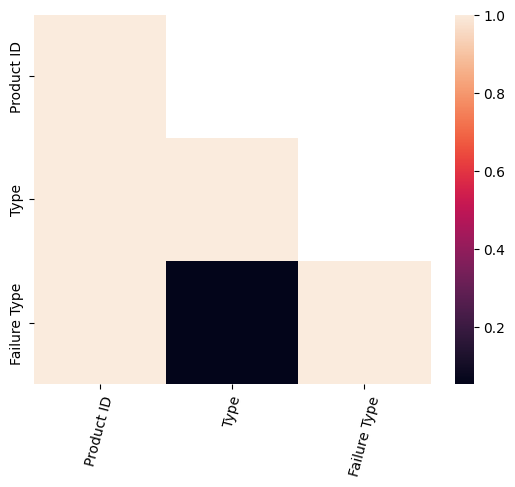

In [19]:
nominal_features = ['Product ID', 'Type', 'Failure Type']
cramersv_corr = pd.DataFrame(
    [[(row, col) for row in nominal_features] for col in nominal_features], columns=nominal_features, index=nominal_features
)
cramersv_corr = cramersv_corr.map(
    lambda x: cramers_v(x, df=clean_train_df)
)
cat_mask = np.tril(cramersv_corr) == 0

fig, axes = plt.subplots(
    figsize=(6.4, 4.8)
)
sns.heatmap(
    cramersv_corr, mask=cat_mask, ax=axes
)
xtick_labels = [item.get_text() for item in axes.get_xticklabels()]
axes.set_xticklabels(xtick_labels, rotation=75);

### Categorical-continuous
* Spearman's rank indicates 'UDI' is correlated with both 'Process temperature' and 'Air temperature'

* A series of boxplots are used to visualise the frequency distributions for continuous variables for different categories in the 'Target', 'Failure Type' and 'Type' columns. 

    * There is an association between type of machine failure and all continuous variables.
 
    * There doesn't appear to be a significant association between product 'Type' and any of the continuous variables.

In [20]:
continuous_features = clean_train_df.select_dtypes('number').columns
correlation_list = []
for col in continuous_features:
    spearman_corr, _ = spearmanr(
        clean_train_df['UDI'], clean_train_df[col]
    )
    correlation_list.append(
        ('UDI', col, spearman_corr)
    )

correlation_list = sorted(
    correlation_list, key=lambda x: np.abs(x[2]), reverse=True
)
correlation_df = pd.DataFrame(
    correlation_list, columns=['variable_1', 'variable_2', 'correlation']
)
correlation_df

,variable_1,variable_2,correlation
0,UDI,Process temperature [K],0.319732
1,UDI,Air temperature [K],0.109248
2,UDI,Tool wear [min],-0.014614
3,UDI,Rotational speed [rpm],0.001957
4,UDI,Torque [Nm],-0.000426


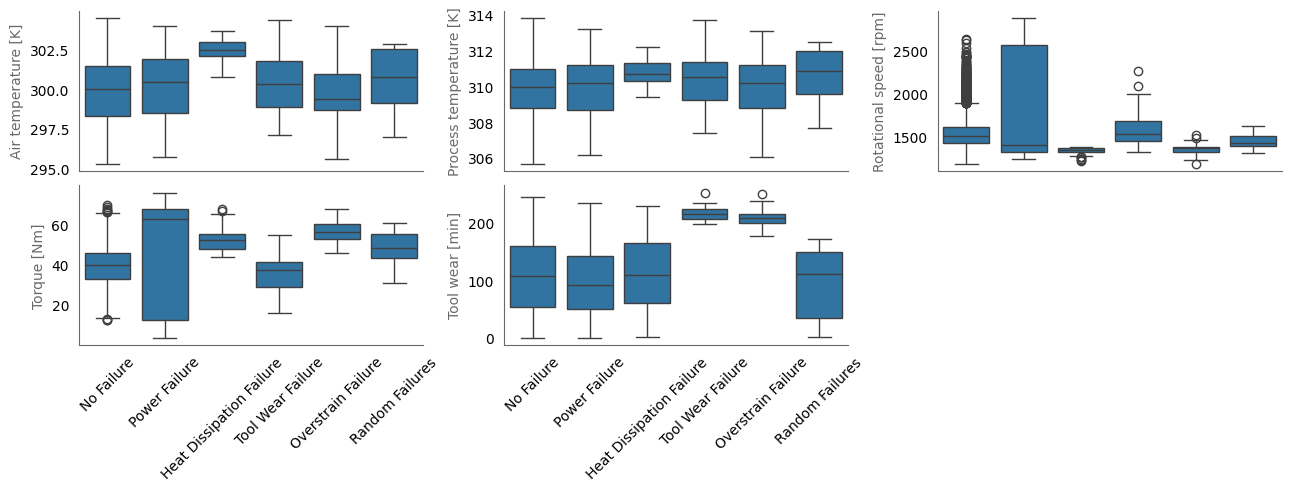

In [21]:
# Boxplot: Failure Type vs Continuous variables
fig, axes = plt.subplots(
    nrows=2, ncols=3, sharex=True, constrained_layout=True, figsize=(6.4*2, 4.8)
)
i = 0
axes = axes.flatten()
for col in clean_train_df.select_dtypes('number'):
    sns.boxplot(x='Failure Type', y=col, data=clean_train_df, ax=axes[i])
    axes[i].set_ylabel(col, fontsize=10, color='dimgray')
    axes[i].set_xlabel('')
    axes[i].set_xticks(range(len(clean_train_df['Failure Type'].unique())))
    axes[i].set_xticklabels(
        clean_train_df['Failure Type'].unique(), rotation=45)
    i += 1

for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')
fig.delaxes(axes[5])

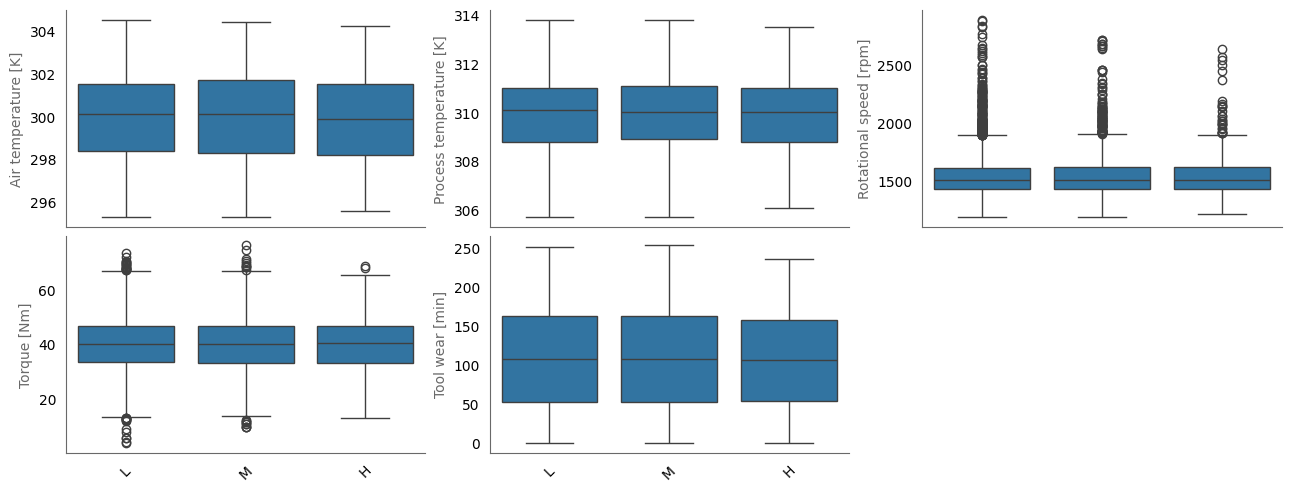

In [22]:
# Boxplot: Type vs Continuous variables
fig, axes = plt.subplots(
    nrows=2, ncols=3, sharex=True, constrained_layout=True, figsize=(6.4*2, 4.8)
)
i = 0
axes = axes.flatten()
for col in clean_train_df.select_dtypes('number'):
    sns.boxplot(x='Type', y=col, data=clean_train_df, ax=axes[i])
    axes[i].set_ylabel(col, fontsize=10, color='dimgray')
    axes[i].set_xlabel('')
    axes[i].set_xticks(range(len(clean_train_df['Type'].unique())))
    axes[i].set_xticklabels(
        clean_train_df['Type'].unique(), rotation=45)
    i += 1

for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')
fig.delaxes(axes[5])

### Multicollinearity
* Condition index is used to assess multicollinearity for categorical and continuous variables (seperately).

    *Note: The impact of multicollinearity may vary between categorical and continuous variables. For example, multicollinearity among continuous variables may affect the precision of regression coefficients, while multicollinearity among categorical variables may affect the interpretation of the reference category or the overall significance of the categorical variable.*

* This analyses indicate no multicollinearity between categorical variables.

* However, a high condition index suggests strong multicollinearity amongst the continuous variables. 

#### Background

**_1) Eigenvectors & eigenvalues_**

* Factorising a covariance matrix gives eigenvectors and corresponding eigenvalues

* Eigenvectors are orthogonal directions in the feature space along which data varies

* A principal components is formed by projecting data points onto an eigenvector

    *Note: Principal components are independent as eigen vectors are orthogonal*

* Eigenvalues are proportional to the variance of data along the direction of the corresponding eigenvector

**_2) Computing condition index_**

1. Factorising the covariance matrix gives eigenvectors and corresponding eigenvalues

2. Condition index is computed using the ratio of the maximum and minimum eigenvalues:

    $\text{Condition index} = \sqrt{\frac{\lambda_{max}}{\lambda_{min}}}$

    *Where $\lambda_{max}$ is the largest eigen value and $\lambda_{min}$ is the smallest.*

**_b) Intepretating condition index_**

* Eigenvalues equal to $0$ indicate perfect multicollinearity:

    $\text{Condition index} = NaN:$ -> *Perfect multicollinearity results in zero eigenvalue(s) and undefined condition index*

* A high proportion of variance explained by few components may suggest multicollinearity

* Eigenvalues close to $0$ indicate multicollinearity:

    $\text{Condition index} = 1:$ -> *Eigen values similar in size - no multicollinearity*

    $\text{Condition index} > 30:$ -> *Large disparity in size - multicollinearity*

#### Analyses

**1) Continuous variables**

In [23]:
# Calculate the covariance matrix
cov_matrix = np.cov(clean_train_df.select_dtypes('number'), rowvar=False)

# Compute the eigenvalues
eigenvalues = np.linalg.eigvals(cov_matrix)

# Compute the condition index
condition_index = np.sqrt(max(eigenvalues)) / np.sqrt(min(eigenvalues))

print("Condition Index:", condition_index)

Condition Index: 307.2754638387104


**2) Categorical variables**

In [26]:
# One-hot encode categorical variables
data_encoded = pd.get_dummies(clean_train_df, columns=['Type', 'Failure Type'], drop_first=True)

# Calculate the covariance matrix
cov_matrix = np.cov(data_encoded.select_dtypes('boolean'), rowvar=False) 

# Compute the eigenvalues
eigenvalues = np.linalg.eigvals(cov_matrix)

# Compute the condition index
condition_index = np.sqrt(max(eigenvalues)) / np.sqrt(min(eigenvalues))

print("Condition Index:", condition_index)

Condition Index: 18.31706225266619


# Predictive modelling

## Background

**_What is multi-class classification?_**

* A classification task with more than two classes. Each sample can only be labeled as one class.

    Note: Multiclass classification is different to multi-label classification, where multiple labels are to be predicted for each instance.

**_Strategies_**

* Multi-class classification techniques can be categorised into two categories:

    1. **Transformation to binary**

       Strategy: Decompose the problem into multiple binary classification subproblems.
      
    2. **Extension from binary**
 
       Strategy: Extend an existing binary classifier.

### Transformation to binary

**a) OVO: One vs. One**

Set-up:

* Targets form a discrete set

  $y \in \{1, 2,...,K\}$

    *Where $K$ is the number of classes.*

Training:

* A binary classifier is trained for every pair of classes:

    $\text{No. of classifiers}=\frac{k \times (k-1)}{2!}$

* A subset of the training data, containing only the two classes, is used during training.

Prediction:

* All classifiers are used and a voting scheme applied.

* The class with the most votes is chosen as the final prediction:

    $\hat{y}_{final} = \underset{k}{\operatorname{argmax}} \sum_i 1\bigl(h_i(\boldsymbol{x})=k\bigr)$
 
    *Where $h_i(\boldsymbol{x})$ is the output of classifier $i$ and $1\bigl(h_i(\boldsymbol{x})=k\bigr)$ returns $1$ when it returns classification $k$ and $0$ otherwise.*

Example:

* Three classes $\{A, B, C\}$

* The following binary classifiers are trained:

  $\text{Classifier 1} = \text{A vs. B}$

  $\text{Classifier 2} = \text{A vs. C}$
  
  $\text{Classifier 3} = \text{B vs. C}$

Drawbacks:

* Some classes may receive the same number of votes.

  Resolving ties requires choosing the class with the highest total confidence or probability across all classifiers.

* Computationally demanding. It requires $O(k^2)$ classifiers.

  The number of classifiers required is high.

**b) OVR: One vs. Rest**

* Also known as OVA (One vs. All)

Set-up:

* Targets form a discrete set

  $y \in \{1, 2,...,K\}$

    *Where $K$ is the number of classes.*

Training:

* All training data is used.

* A binary classifier is trained for each class against the rest of the classes.

    $\text{No. of classifiers}=K$

    Note: It requires $O(K)$ classifiers. This means OVR is more efficient than OVO.

Prediction:

* All classifiers are utilised.

* The final prediction is the class for which the corresponding classifier reports the highest confidence score:

    $\hat{y}_{final} = \underset{k \in \{1...K\}}{\operatorname{argmax}} h_k(\boldsymbol{x})$
 
    *Where $h_k(\boldsymbol{x})$ is the output of classifier $k$.*

Example:

* Three classes $\{A, B, C\}$

* The following binary classifiers are trained:

  $\text{Classifier 1} = \text{A vs. (B,C)}$

  $\text{Classifier 2} = \text{B vs. (A,C)}$
  
  $\text{Classifier 3} = \text{C vs. (A, B)}$

Drawbacks:

* Aggregation of different classes leads to imbalanced datasets and sometimes suboptimal performance on the minority target class.

### Extension from binary

These strategies extend existing binary classifiers to solve multi-class classification problems.

**a) Naive Bayes**

* The algorithm can naturally handle binary or multiclass classification problems

* Simply choose the classification $k$ that maximises $p(C_k | \boldsymbol{x})$:

    $\hat{y} = \underset{k \in 1...K}{\operatorname{argmax}} p(C_k|\boldsymbol{x})$

    $\hat{y} = \underset{k \in 1...K}{\operatorname{argmax}} p(C_k)\prod_{i=1}^n p(x_i | C_k)$

    *Where $\boldsymbol{x}$ is the vector of $n$ features for a single test instance being classified.*
 
**b) Softmax regression (or multinomial logistic regression)**

* Softmax regression  is a generalisation of logistic regression to a multiclass problem

Logistic regression:

* One weight vector $\theta$ is learnt.

    *Note: Weights are computed using the log-likelihood function*

* The log-odds $z$ (AKA logit) for a single data point $(\boldsymbol{x},y)$ is given by a linear combination of features $x_i$ and weights $\theta_i$:

    $z=\sum_{i=0}^{m}\theta_ix_i = \theta^T\boldsymbol{x}$

    $log\bigl(odds\bigr) = log\bigl(\frac{P(Y = 1|\boldsymbol{X} = \boldsymbol{x})}{1 - P(Y = 1|\boldsymbol{X} = \boldsymbol{x})}\bigr) = \theta^T\boldsymbol{x}$

    *Where, $\theta$ is a vector of parameters of length $m$ and $\boldsymbol{x}$ is a vector of values for each predictor variable (note: $x_0$ is always set to $1$)*.

* $P(Y|X)$ can then be approximated by applying a sigmoid function to the log-odds:

    $\sigma(z)=\frac{1}{1+e^{-z}}$, where $\forall z \in R$, $\sigma(z) \in [0,1]$

    $P(Y = 1|\boldsymbol{X} = \boldsymbol{x}) = \sigma(z)$

    $P(Y = 1|\boldsymbol{X} = \boldsymbol{x}) = \sigma(\theta^T\boldsymbol{x})$

    $P(Y = 1|\boldsymbol{X} = \boldsymbol{x}) = \frac{1}{1+exp(-\theta^T\boldsymbol{x})}$

    *Where, $\sigma(\cdot)$ is the sigmoid function.*

* The decision rule is based on whether the predicted probability is greater than a specified threshold.

    $ \hat{y} = \begin{cases} 
    1 & \text{if } P(Y = 1|\boldsymbol{X} = \boldsymbol{x}) \geq 0.5 \\
    0 & \text{if } P(Y = 1|\boldsymbol{X} = \boldsymbol{x}) < 0.5
    \end{cases}$

Softmax regression:

* One set of weights is learnt for each class $\theta^{(k)}$

    *Note: Weights are computed at the same time using a vector objective function.*

* For a single data point $(\boldsymbol{x},y)$, the logit for each class $z^{(k)}$ is given by a linear combination of features $x_i$ and the relevant weights $\theta^{(k)}$:

    $z^{(k)}=\sum_{i=0}^{m}\theta_i^{(k)}x_i = \theta^{(k)T}\boldsymbol{x}$

    *Where, $\theta$ is a vector of parameters of length $m$ and $\boldsymbol{x}$ is a vector of values for each predictor variable (note: $x_0$ is always set to $1$)*.

* The softmax function is then applied to these raw scores to obtain normalized class probabilities:

    $P(y=k | \boldsymbol{x}; \theta) = \frac{exp\bigl(z^{(k)}\bigr)}{\sum_{j=1}^K exp\bigl(z^{(j)}\bigr)}$

    $P(y=k | \boldsymbol{x}; \theta) = \frac{exp\bigl(\theta^{(k)T}\boldsymbol{x}\bigr)}{\sum_{j=1}^K exp\bigl(\theta^{(j)T}\boldsymbol{x}\bigr)}$
    
* The decision rule is based on selecting the class with the highest predicted probability:

    $\hat{y}_{final} = \underset{k \in \{1...K\}}{\operatorname{argmax}} P(y=k | \boldsymbol{x}; \theta)$

[Source](http://deeplearning.stanford.edu/tutorial/supervised/SoftmaxRegression/)

**c) Random forest**

* The algorithm can naturally handle binary or multiclass classification problems.

* Decicision rules are learnt by repeatedly partitioning training data using predictor values that maximise within partition homogeneity (i.e. class purity) for classification tasks

* The class with the most votes is chosen:

    $\hat{y}_{final} = \underset{k}{\operatorname{argmax}} \sum_i 1\bigl(h_i(\boldsymbol{x})=k\bigr)$
 
    *Where $h_i(\boldsymbol{x})$ is the output of tree $i$ and $1\bigl(h_i(\boldsymbol{x})=k\bigr)$ returns $1$ when it returns classification $k$ and $0$ otherwise.*

**d) XGBoost**

* The idea of boosting methods is to combine several weak learners to form a stronger one.

* In gradient boosting, weak learners are trained sequentially on residuals

Binary setting:

* The final model is a stagewise additive model of $T$ individual trees

* The log-odds $z$ (AKA logit) for a single data point $(\boldsymbol{x},y)$ is given by the sum of the sequence of weak learners:

    $z = H_T(\boldsymbol{x}) = \sum_{t=1}^T h_t(\boldsymbol{x})$

  *Where $H_T$ is the ensemble and $T$ is number of consitutent learners*

* The logit is transformed into a probability using a sigmoid function.

    $P(Y = 1|\boldsymbol{X} = \boldsymbol{x}) = \frac{1}{1+exp(-z)}$

    *Where, $\sigma(\cdot)$ is the sigmoid function.*

* The decision rule is based on whether the predicted probability is greater than a specified threshold.

    $ \hat{y} = \begin{cases} 
    1 & \text{if } P(Y = 1|\boldsymbol{X} = \boldsymbol{x}) \geq 0.5 \\
    0 & \text{if } P(Y = 1|\boldsymbol{X} = \boldsymbol{x}) < 0.5
    \end{cases}$

Multiclass setting:

* Distinct weak learners are trained for each class

    *Note: In reality, these are computed at the same time using a vector objective function.*

* The predictions from all class-specific trees are aggregated to form a final score for each class.

    $z^{(k)} = H_T^{(k)}(\boldsymbol{x}) = \sum_{t=1}^T h_t^{(k)}(\boldsymbol{x})$

  *Where $H_T^{(k)}$ is the ensemble for class $k$ and $T$ is number of consitutent learners*

* The softmax function is then applied to these raw scores to obtain normalized class probabilities:

    $P(y=k | \boldsymbol{x}; \theta) = \frac{exp\bigl(z^{(k)}\bigr)}{\sum_{j=1}^K exp\bigl(z^{(j)}\bigr)}$
  
* The decision rule is based on selecting the class with the highest predicted probability:

    $\hat{y}_{final} = \underset{k \in \{1...K\}}{\operatorname{argmax}} P(y=k | \boldsymbol{x}; \theta)$

[Source](https://stats.stackexchange.com/questions/204154/classification-with-gradient-boosting-how-to-keep-the-prediction-in-0-1)

[Source](https://bradleyboehmke.github.io/HOML/gbm.html#feature-interpretation-1)

## Strategy

### Model types

* An "extension from binary" strategy will be used.

* This will prevent loss of information about the multiclass relationships and reduce model complexity (i.e. one-vs-one would result in a large number of binary classifiers.)

* A Random Forest will be tested as this type of model performed the best for the binary classification problem.
  
    - Random Forest (discriminative probabilistic model & non-linear classifier)

### Performance metrics

**Background**

* In the context of a multiclass problem, micro and macro averaging are commonly used to summarise performance across multiple classes.

* Micro-averaging considers all instances equally and is therefore more influenced by the performance on larger classes.

    $Micro-Recall = \frac{\sum_{i=1}^KTP_i}{\sum_{i=1}^K\bigl(TP_i + FN_i\bigr)}$

    $Micro-Precision = \frac{\sum_{i=1}^KTP_i}{\sum_{i=1}^K\bigl(TP_i + FP_i\bigr)}$

    $Micro-F1 = \frac{2 \times micro-recall \times micro-precision}{micro-recall + micro-precision}$

    *Where $K$ is the number of classes.*

* Whilst macro-averaging treats all classes equally and therefore gives a more balanced view of performance across all classes.

    $Macro-Recall = \frac{1}{K}\sum_{i=1}^K\frac{TP_i}{TP_i + FN_i}$

    $Macro-Precision = \frac{1}{K}\sum_{i=1}^K\frac{TP_i}{TP_i + FP_i}$

    $Macro-F1 = \frac{2}{K}\sum_{i=1}^K\frac{micro-recall_i \times micro-precision_i}{micro-recall_i + micro-precision_i}$

    *Where $K$ is the number of classes.*

**Strategy**

* The performance metrics should align closely with the specific business problem at hand.

* While a single metric simplifies ranking model performance, the dataset's imbalance makes overall accuracy unsuitable.

* It is assumed the cost of a false negative prediction (incorrectly identifying something as okay when it has failed) outweighs the cost of a false positive prediction.

* The primary metric is therefore macro-recall across the failure classes, reflecting the model's ability to identify failed machinery and aiming to minimise false negatives.

* A secondary metric is macro-precision across the failure classes, thereby minimising false positives and ensuring high accuracy in failed predictions. The optimisation target is a nominal constraint of 50% precision.

* Striking a balance involves achieving a reasonable level of precision to prevent unnecessary disruptions while maintaining a sufficiently high recall for effective fault detection. With this in mind, Macro-F1 score will be used during optimisation.

    Note: AUC on the Precision-Recall for each class would allow for the comparison of different models in terms of their ability to balance precision and recall. However, this reduces the problem to an OVA strategy.

## Import raw data

* **UID:** Unique identifier ranging from 1 to 10000

* **productID:** Consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number

* **air temperature [K]:** Generated using a random walk process later normalized to a standard deviation of 2 K around 300 K

* **process temperature [K]:** Generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.

* **rotational speed [rpm]:** Calculated from powepower of 2860 W, overlaid with a normally distributed noise

* **torque [Nm]:** Torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.

* **tool wear [min]:** The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a 'machine failure' label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true.

* **Target:** Failure or Not

* **Failure Type:** Type of Failure

## Import cleaned data

In [ ]:
train_df = pd.read_csv(cf.file_directory('cleaned') + 'train_df.csv')
test_df = pd.read_csv(cf.file_directory('cleaned') + 'test_df.csv')
train_df.head()

## Train/test prep

In [ ]:
# Predictors
cols = ['Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]', 'Type_H', 'Type_L', 'Type_M']
X_train = train_df[cols]
X_test = test_df[cols]
X_train.head()

In [ ]:
# Target
y_train = train_df.filter(regex=("Failure Type.*"))
y_test = test_df.filter(regex=("Failure Type.*"))

# Reverse one hot encoding
y_train = y_train.idxmax(axis=1)
y_test = y_test.idxmax(axis=1)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the reversed target variable
y_train = pd.Series(label_encoder.fit_transform(y_train))
y_test = pd.Series(label_encoder.fit_transform(y_test))

# Label mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

## Model training

### Random forest

**Hyperparameter selection**

* The following hyperparameters are optimised:
       
    1. The number of estimators.
       
    2. The maximum depth of the trees.
       
        Note: If None, then nodes are expanded until all leaves are pure or until all leaves contain less than *min_samples_split* samples.

    3. The minimum number of samples required to split an internal node is optimised.

In [ ]:
# Create a pipeline with a scaler and classifier
num_cols = ['Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
preprocessor = ColumnTransformer(transformers=[('scaler', MinMaxScaler(), num_cols)], remainder='passthrough')
pipe = Pipeline([('preprocessor', preprocessor), ('rf', RandomForestClassifier())])

# Define hyperparameters to tune
param_grid = {
    'rf__n_estimators': [100],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5, 10],
}

# Use StratifiedKFold for cross-validation to maintain class balance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create a custom scoring function for macro F1 score with subset of classes
# Note: zero_division=0 means that if there are no predicted samples for a class, the precision, recall, or F1 score for that class will be set to 0
subset_classes = [0, 2, 3, 4, 5] 
macro_f1_subset = make_scorer(f1_score, average='macro', labels=subset_classes,zero_division=0)

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring=macro_f1_subset)
grid_search.fit(X_train, y_train)

# Get the best estimator from grid search
best_pipeline = grid_search.best_estimator_
print("Best n_estimators:", grid_search.best_params_['rf__n_estimators'])
print("Best max_depth:", grid_search.best_params_['rf__max_depth'])
print("Best min_samples_split:", grid_search.best_params_['rf__min_samples_split'])

**Performance**

* K-fold cross validation is used to assess the performance of the optimal configuration.

* A stratified split is used to maintain the class balance.

**_Key observations_**

* Recall is $TBC$. This means the model identifies $TBC\%$ of all failed machinery.

    $Recall = \frac{TP}{TP+FN}$

* Precision is $TBC$. This means roughly $TBC\%$ of failed predictions are correct.

    $Precision = \frac{TP}{TP+FP}$

In [ ]:
best_params = {key.lstrip('rf__'):value for key, value in grid_search.best_params_.items()}

# Use StratifiedKFold for cross-validation to maintain class balance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create custom macro scoring functions
# Note: zero_division=0 means that if there are no predicted samples for a class, the precision, recall, or F1 score for that class will be set to 0
macro_f1_subset = make_scorer(f1_score, average='macro', labels=subset_classes, zero_division=0)
macro_precision_subset = make_scorer(precision_score, average='macro', labels=subset_classes, zero_division=0)
macro_recall_subset = make_scorer(recall_score, average='macro', labels=subset_classes, zero_division=0)

# Iterate over k-folds
macro_precision, macro_recall, macro_f1 = [], [], []
for train_index, test_index in cv.split(X_train, y_train):
    X_train_k, y_train_k = X_train.loc[train_index], y_train.loc[train_index]
    X_test_k, y_test_k = X_train.loc[test_index], y_train.loc[test_index]

    # Create a pipeline with a classifier and a scaler
    num_cols = ['Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
    preprocessor = ColumnTransformer(transformers=[('scaler', MinMaxScaler(), num_cols)], remainder='passthrough')
    pipe = Pipeline([('preprocessor', preprocessor), ('rf', RandomForestClassifier(**best_params))])

    # Perform predictions
    pipe.fit(X_train_k, y_train_k)
    
    # Calculate precision, recall & f1-score
    precision_k = macro_precision_subset(pipe, X_test_k, y_test_k)
    recall_k = macro_recall_subset(pipe, X_test_k, y_test_k)
    f1_k = macro_f1_subset(pipe, X_test_k, y_test_k)

    macro_precision.append(precision_k)
    macro_recall.append(recall_k)
    macro_f1.append(f1_k)

print(f"Macro-Precision: {np.mean(macro_precision)}")
print(f"Macro-Recall: {np.mean(macro_recall)}")
print(f"Macro-F1: {np.sqrt(np.mean(macro_f1))}")

### Random Forest with SMOTE

**Hyperparameter selection**

* The following hyperparameters are optimised:
       
    1. The number of estimators.
       
    2. The maximum depth of the trees.
       
        Note: If None, then nodes are expanded until all leaves are pure or until all leaves contain less than *min_samples_split* samples.

    3. The minimum number of samples required to split an internal node is optimised.
 
    4. The SMOTE sampling strategy.

In [ ]:
# Test smote resampling
print(f"Original dataset shape: {collections.Counter(y_train)}")
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print(f"Resampled: {collections.Counter(y_res)}")

In [ ]:
# Create a pipeline with a scaler, SMOTE and classifier
num_cols = ['Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
preprocessor = ColumnTransformer(transformers=[('scaler', MinMaxScaler(), num_cols)], remainder='passthrough')
pipe = make_pipeline(preprocessor, SMOTE(random_state=42), RandomForestClassifier())

# Define hyperparameters to tune
param_grid = {
    'randomforestclassifier__n_estimators': [50, 100, 150],
    'randomforestclassifier__max_depth': [None, 10, 20],
    'randomforestclassifier__min_samples_split': [20, 30, 40],
}

# Use StratifiedKFold for cross-validation to maintain class balance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create a custom scoring function for macro F1 score with subset of classes
# Note: zero_division=0 means that if there are no predicted samples for a class, the precision, recall, or F1 score for that class will be set to 0
subset_classes = [0, 2, 3, 4, 5] 
macro_f1_subset = make_scorer(f1_score, average='macro', labels=subset_classes, zero_division=0)

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring=macro_f1_subset)
grid_search.fit(X_train, y_train)

# Get the best estimator from grid search
best_pipeline = grid_search.best_estimator_

# Print the best parameters
print("Best n_estimators:", grid_search.best_params_['randomforestclassifier__n_estimators'])
print("Best max_depth:", grid_search.best_params_['randomforestclassifier__max_depth'])
print("Best min_samples_split:", grid_search.best_params_['randomforestclassifier__min_samples_split'])

**Performance**

* K-fold cross validation is used to assess the performance of the optimal configuration.

* A stratified split is used to maintain the class balance.

**_Key observations_**

* Recall is $TBC$. This means the model identifies $TBC\%$ of all failed machinery.

    $Recall = \frac{TP}{TP+FN}$

* Precision is $TBC$. This means roughly $TBC\%$ of failed predictions are correct.

    $Precision = \frac{TP}{TP+FP}$

In [ ]:
rf_best_params = {key:value for key, value in grid_search.best_params_.items() if 'randomforestclassifier__' in key}
rf_best_params = {key.replace('randomforestclassifier__',''):value for key, value in rf_best_params.items()}

# Use StratifiedKFold for cross-validation to maintain class balance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create custom macro scoring functions
# Note: zero_division=0 means that if there are no predicted samples for a class, the precision, recall, or F1 score for that class will be set to 0
macro_f1_subset = make_scorer(f1_score, average='macro', labels=subset_classes, zero_division=0)
macro_precision_subset = make_scorer(precision_score, average='macro', labels=subset_classes, zero_division=0)
macro_recall_subset = make_scorer(recall_score, average='macro', labels=subset_classes, zero_division=0)

# Iterate over k-folds
macro_precision, macro_recall, macro_f1 = [], [], []
for train_index, test_index in cv.split(X_train, y_train):
    X_train_k, y_train_k = X_train.loc[train_index], y_train.loc[train_index]
    X_test_k, y_test_k = X_train.loc[test_index], y_train.loc[test_index]

    # Convert y_train_k and y_test_k to NumPy arrays
    y_train_k_np = np.array(y_train_k)
    y_test_k_np = np.array(y_test_k)

    # Create a pipeline with a classifier and a scaler
    num_cols = ['Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
    preprocessor = ColumnTransformer(transformers=[('scaler', MinMaxScaler(), num_cols)], remainder='passthrough')
    pipe = make_pipeline(preprocessor, SMOTE(random_state=42), RandomForestClassifier(**rf_best_params))

    # Perform predictions
    pipe.fit(X_train_k, y_train_k_np)
    
    # Calculate precision, recall & f1-score
    precision_k = macro_precision_subset(pipe, X_test_k, y_test_k_np)
    recall_k = macro_recall_subset(pipe, X_test_k, y_test_k_np)
    f1_k = macro_f1_subset(pipe, X_test_k, y_test_k_np)

    macro_precision.append(precision_k)
    macro_recall.append(recall_k)
    macro_f1.append(f1_k)

print(f"Macro-Precision: {np.mean(macro_precision)}")
print(f"Macro-Recall: {np.mean(macro_recall)}")
print(f"Macro-F1: {np.sqrt(np.mean(macro_f1))}")

## Model evaluation

| Model | Macro-Recall | Macro-Precision | Macro-F1 |
|----------|----------|----------|----------|
| Random Forest   | 0.25   | 0.33   | 0.52   |
| Random Forest with SMOTE   | 0.52   | 0.31   | 0.6   |

In [ ]:
# Retrain with entire training set
num_cols = ['Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
preprocessor = ColumnTransformer(transformers=[('scaler', MinMaxScaler(), num_cols)], remainder='passthrough')
pipe = make_pipeline(preprocessor, SMOTE(random_state=42), RandomForestClassifier(**rf_best_params))
pipe.fit(X_train, y_train)

In [ ]:
# Evaluate with test set

# Predict
y_pred = pipe.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
# Source: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
confusion_matrices_count = confusion_matrix(y_test, y_pred)
confusion_matrices_perc = confusion_matrix(y_test, y_pred, normalize='true')*100

# Plot confusion matrix
confusion_matrices_perc  = confusion_matrices_perc .round(1)
labels = [f"{c}\n{p}%" for c, p in zip(confusion_matrices_count.flatten(), confusion_matrices_perc.flatten())]
labels = np.asarray(labels).reshape(6, 6)

fig, axes = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(6.4, 4.8))
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

sns.heatmap(confusion_matrices_perc, ax=axes, annot=labels, fmt="s", annot_kws={"fontsize":10})
axes.set_xlabel('Actual',fontsize=15, color='dimgray')
axes.set_ylabel('Predicted',fontsize=15, color='dimgray');

In [ ]:
print("Label Mapping:", label_mapping)

### Conclusion